### Regression model for interpolating or calculating hot water energy

In [1]:
!git clone --branch master https://github.com/AvisekNaug/HWS_regressionmodel.git

Cloning into 'HWS_regressionmodel'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 3), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [2]:
cd HWS_regressionmodel

/content/HWS_regressionmodel


In [0]:
from pandas import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [0]:
months = ['March19', 'April19', 'May19', 'June19', 'July19', 'August19']
dataframe = read_excel('Data.xlsx', sheet_name=months)

In [0]:
df = concat(dataframe.values(), axis=0, join='outer')

In [0]:
def tryhard(datestring):
    try:
        value = to_datetime(datestring, format='%m/%d/%y, %I:%M:%S %p CST')
    except ValueError:
        value= to_datetime(datestring, format='%m/%d/%y, %I:%M:%S %p CDT') - Timedelta(hours=1)  
    return value

In [0]:
df.insert(loc=0, column='Dates', value=df['Time'].apply(lambda x: tryhard(x)))
df.set_index(['Dates'], drop=True, inplace=True)
df.drop('Time',axis=1,inplace=True)#Drop original Time column

In [0]:
#Selecting time points only at 5 minute intervals
mask = np.logical_and((df.index.minute % 5) == 0, (df.index.second) == 0)
df = df[mask]
df.dropna(axis=0,how='any',inplace=True)

In [0]:
#rearranging columns
df = df[[df.columns[i] for i in [4,3,1,2,5,0]]]

In [0]:
#Correlation plot
import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 10))
dft = df[sorted(df)]
plt.matshow(dft.corr(), fignum=f.number)
plt.xticks(range(dft.shape[1]), dft.columns, fontsize=8, rotation=90)
plt.yticks(range(dft.shape[1]), dft.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);
#plt.savefig("abc.png",dpi=300)
plt.show()

In [12]:
df.head(1)

,Hot Water Pump Output.Hot Water Pump Output.Trend - Present Value (),Reheat Output.Reheat Output.Trend - Present Value (),Hot Water Supply Temperature.Hot Water Supply Temperature.Trend - Present Value (),Hot Water Differential Pressure.Hot Water Differential Pressure.Trend - Present Value (),Hot Water Return Temperature.Hot Water Return Temperature.Trend - Present Value (),Flow Rate.Trend - Present Value ()
Dates,,,,,,
2019-03-11 19:00:00,0.0,0.0,102.2685,-0.692281,98.40254,0.0


## Preparing the training, validation and test data

In [0]:
oddData = df.iloc[::2]
evenData = df.iloc[1::2]

#Training data
X, y = oddData.iloc[:,:-1], oddData.iloc[:,-1]
#catogorical_features_indices=np.where(X.dtypes != np.float)[0]

X_i = X.to_numpy()
y_o = y.to_numpy()

lag = 1

X_train = X_i[:-1*lag]
y_train = y_o[lag:]


#Validation Data
valData = evenData.iloc[::2]
#X, y = valData.iloc[:,:-1], valData.iloc[:,-1]
X, y = evenData.iloc[:int(evenData.shape[0]/2),:-1], evenData.iloc[:int(evenData.shape[0]/2),-1]


X_i = X.to_numpy()
y_o = y.to_numpy()

X_val = X_i[:-1*lag]
y_val = y_o[lag:]

#Test Data
testData = evenData.iloc[1::2]
#X, y = testData.iloc[:,:-1], testData.iloc[:,-1]
X, y = evenData.iloc[int(evenData.shape[0]/2):,:-1], evenData.iloc[int(evenData.shape[0]/2):,-1]

X_i = X.to_numpy()
y_o = y.to_numpy()

X_test = X_i[:-1*lag]
y_test = y_o[lag:]

## Evaluating the model

In [0]:
#testing metric
def testerror(X_arg, y_targ, modelname, learner):
    y_predicted_test = learner.predict(X_arg)
    cvrmse = sqrt(mean_squared_error(y_targ, y_predicted_test))/y_targ.mean(axis=0)
    print ("CVRMSE on test data is for {} model is {}".format(modelname,cvrmse))
    return y_predicted_test

## Creating a boosting regression model

In [15]:
#training using gradient boosted regression
modelname = 'gradient boosting'
from sklearn.ensemble import GradientBoostingRegressor as GBR
learner = GBR(n_estimators=1000)
learner.fit(X_train,y_train)
print ("R^2 coefficienct of determination is {}".format(learner.score(X_test,y_test)))

#See feature importances
names = list(X.columns[np.argsort(-1*learner.feature_importances_)])
featuresimps = learner.feature_importances_
importancevalue = list(featuresimps[np.argsort(-1*featuresimps)])
for i in range(len(names)):
    print ((names[i],importancevalue[i]))
y_predicted_test = testerror(X_test,y_test,modelname, learner)

R^2 coefficienct of determination is 0.972182946188814
('Hot Water Pump Output.Hot Water Pump Output.Trend - Present Value ()', 0.6062669318088175)
('Hot Water Return Temperature.Hot Water Return Temperature.Trend - Present Value ()', 0.17896552288735665)
('Reheat Output.Reheat Output.Trend - Present Value ()', 0.15891738304314507)
('Hot Water Supply Temperature.Hot Water Supply Temperature.Trend - Present Value ()', 0.037363567662146824)
('Hot Water Differential Pressure.Hot Water Differential Pressure.Trend - Present Value ()', 0.01848659459853377)
CVRMSE on test data is for gradient boosting model is 0.15663895994445198


## Simple MLP regression  model

In [0]:
from sklearn.neural_network import MLPRegressor
modelname = 'MLP regression'
learner = MLPRegressor(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(30, 30, 30), random_state=1, max_iter=300)
learner .fit(X_train,y_train)
print ("R^2 coefficienct of determination is {}".format(learner.score(X_test,y_test)))
y_predicted_test = testerror(X_test,y_test,modelname, learner)

R^2 coefficienct of determination is 0.8488456530952075
CVRMSE on test data is for MLP regression model is 0.3651359095815076


## Polynomial model

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
modelname = 'polynomial regression'
learner = make_pipeline(PolynomialFeatures(degree = 4),LinearRegression())
learner.fit(X_train,y_train)
print ("R^2 coefficienct of determination is {}".format(learner.score(X_test,y_test)))
y_predicted_test = testerror(X_test,y_test,modelname, learner)

R^2 coefficienct of determination is 0.8174020825497853
CVRMSE on test data is for polynomial regression model is 0.40132123082884286


## Kernel Ridge regression

In [0]:
from sklearn.kernel_ridge import KernelRidge
modelname = 'Kernel Ridge'
learner = KernelRidge(alpha=1.0, kernel = 'rbf')
learner.fit(X_train,y_train)
print ("R^2 coefficienct of determination is {}".format(learner.score(X_test,y_test)))
y_predicted_test = testerror(X_test,y_test,modelname, learner)

R^2 coefficienct of determination is 0.9114689879686161
CVRMSE on test data is for Kernel Ridge model is 0.27944216664120924


## Support Vector Regression

In [0]:
from sklearn.svm import SVR
modelname = 'Support Vector Regression'
learner = SVR(gamma='scale', C=2.0, epsilon=0.8)
learner.fit(X_train,y_train)
print ("R^2 coefficienct of determination is {}".format(learner.score(X_test,y_test)))
y_predicted_test = testerror(X_test,y_test,modelname, learner)

R^2 coefficienct of determination is 0.7277907859309853
CVRMSE on test data is for Support Vector Regression model is 0.4899994993900865


## Running grid search on the parameters for SVR

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
modelname = 'Support Vector Regression'
parameters = [{'kernel':['linear', 'rbf'], 'C':[i for i in range(1,11)], 'epsilon':[0.1, 0.2, 0.4, 0.6]},
             {'kernel':['poly'], 'degree':[3,4,5], 'C':[i for i in range(1,11)], 'epsilon':[0.1, 0.2, 0.4, 0.6]}]
svr = SVR(gamma='scale')
learner = GridSearchCV(svr, parameters, cv=5)
learner.fit(X_train,y_train)

### getting best parameters

In [0]:
learner.best_estimator_

In [0]:
print ("R^2 coefficienct of determination is {}".format(learner.score(X_test,y_test)))
y_predicted_test = testerror(X_test,y_test,modelname, learner)

## Test Data Plot

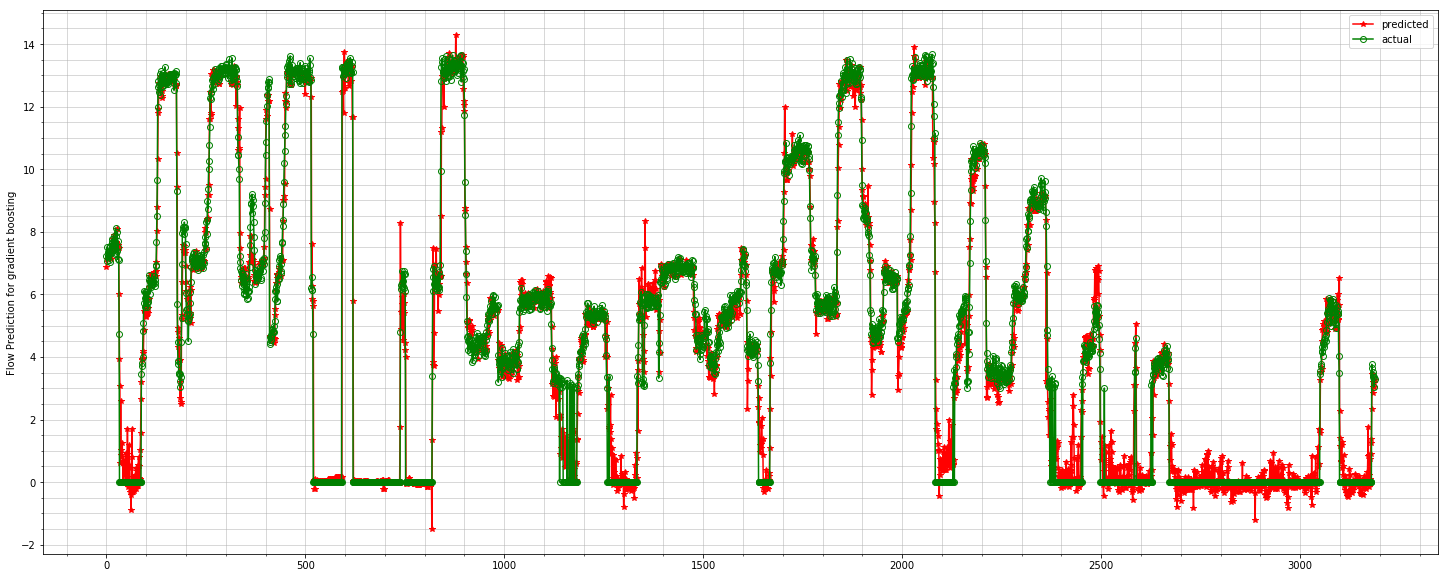

In [23]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [25.0,10.0]
plt.plot(y_predicted_test,'r*-',label='predicted')
plt.plot(y_test,'go-',label='actual',fillstyle='none')
#plt.plot(y_test-y_predicted_test,'go-',label='difference',fillstyle='none')
plt.ylabel('Flow Prediction for '+modelname)
plt.legend()
plt.grid(which='both',alpha=100)
plt.minorticks_on()
plt.show()

In [0]:
y_predicted_test